This is a simple LSTM test with the goal to train to predict a sine wave using PyTorch.

In [121]:
# Created by Davide Pasca - 2023/07/24

import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Tuple

In [122]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print("Using device:", device)

Using device: cuda


We use actual time values to have a realistic view of the number of samples involved if this were about predicting market data.
Of course, the actual price data would be much different.

In [123]:
# Constants
SAMPLE_SIZE_MINS = 60 * 6  # 6 hours

USE_LOG_RETURNS = False

NORMALIZE_TYPE = 'none'  # 'minmax', 'std', 'constant', 'none'

# With log-returns, values tend to be very small
# This is a reasonable scale
CONST_NORM_SCALE = 15.0 if USE_LOG_RETURNS else 1.0

LSTM_INPUT_SIZE = 1  # Only 1 feature (univariate time series data)
LSTM_SEQUENCE_LENGTH = SAMPLE_SIZE_MINS * 6 * 2 // 60
LSTM_LAYERS_N = 1
# https://www.quora.com/How-should-I-set-the-size-of-hidden-state-vector-in-LSTM-in-keras/answer/Yugandhar-Nanda
LSTM_HIDDEN_SIZE = LSTM_SEQUENCE_LENGTH // 1

LEARNING_RATE_ADAM = 0.005
LEARNING_RATE_ADAGRAD = 0.01
LEARNING_RATE_RMS_PROP = 0.0001
LEARNING_RATE_SGD = 0.01
LEARNING_RATE_RADAM = 0.001
LEARNING_RATE_ADAMW = 0.002

L1_REGULARIZATION = 0*0.0001  #

L2_WEIGHT_DECAY = 0.0 # 0.0001

DROPOUT_P = 0.0  # 0 to disable

EPOCHS_N = 50000

In [124]:
def normalizeVal(val):
    return val * NORMALIZE_SCALE + 0.0

def denormalizeVal(val):
    return (val - 0.0) / NORMALIZE_SCALE

def generate_sine_wave(samplesN: int, frequency: float, minVal: float, maxVal: float) -> torch.Tensor:
    amp = (maxVal - minVal) / 2.0
    wave = [float(amp * (math.sin(2.0 * math.pi * frequency * i) + 1.0) + minVal) for i in range(samplesN)]
    return torch.tensor(wave)

def safeLog(vals: torch.Tensor) -> torch.Tensor:
    return torch.where(vals > 0, torch.log(vals), torch.tensor(0.0))

def make_input_data(vals: torch.Tensor) -> Tuple[torch.Tensor, float, float]:
    data = torch.empty_like(vals)  # create an empty tensor of the same size

    if USE_LOG_RETURNS:
        data[1:] = safeLog(vals[1:] / vals[:-1])
        data[0] = data[1]  # copy the second element to the first
    else:
        data = vals

    norm_off = 0.0
    norm_sca = 0.0
    if NORMALIZE_TYPE == 'std':
        norm_off = data.mean()
        norm_sca = data.std()
    elif NORMALIZE_TYPE == 'minmax':
        norm_off = data.min()
        norm_sca = data.max() - data.min()
    elif NORMALIZE_TYPE == 'constant':
        norm_off = 0.0
        norm_sca = CONST_NORM_SCALE
    elif NORMALIZE_TYPE == 'none':
        norm_off = 0.0
        norm_sca = 1.0
    else:
        raise ValueError(f'Unknown normalization type: {NORMALIZE_TYPE}')

    data = (data - norm_off) / norm_sca

    return data, norm_off, norm_sca

def create_sequences(data, seq_len):
    seqs_batch_n = len(data) - seq_len - 1
    sequences = torch.empty((seqs_batch_n, seq_len, 1))
    targets = torch.empty((seqs_batch_n, 1))
    for i in range(seqs_batch_n):
        sequences[i] = data[i:i + seq_len].view(seq_len, 1)
        targets[i] = data[i + seq_len + 1]
    return sequences, targets

In [125]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, layers_n, dropout_p):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers_n, dropout=dropout_p if layers_n > 1 else 0)
        self.dropout = nn.Dropout(dropout_p)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(1), self.lstm.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(1), self.lstm.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out.select(1, -1))  # Select the last element from the seq_len dimension and apply dropout
        out = self.linear(out)
        out = out.squeeze(-1)  # Squeeze the last dimension if your output size is 1
        return out

In [126]:

# Sine wave parameters for our fictitious market history
TESTDATA_MIN_VAL = 1.0
TESTDATA_MAX_VAL = 2.0
TESTDATA_FREQUENCY = 1.0 / 100.0

# How many minutes of history do we have?
TESTDATA_SAMPLES_MINS_N = 60 * 24 * 30 * 3  # 3 months
# Convert the minutes to samples
TESTDATA_SAMPLES_N = TESTDATA_SAMPLES_MINS_N // SAMPLE_SIZE_MINS

# Sine wave parameters for our fictitious market history
TRAINDATA_MIN_VAL = 1.0
TRAINDATA_MAX_VAL = 2.0
TRAINDATA_FREQUENCY = 1.0 / 100.0

# How many minutes of history do we have?
TRAINDATA_SAMPLES_MINS_N = 60 * 24 * 30 * 6  # 6 months
# Convert the minutes to samples
TRAINDATA_SAMPLES_N = TRAINDATA_SAMPLES_MINS_N // SAMPLE_SIZE_MINS

train_prices = generate_sine_wave(TRAINDATA_SAMPLES_N, TRAINDATA_FREQUENCY, TRAINDATA_MIN_VAL, TRAINDATA_MAX_VAL)
test_prices = generate_sine_wave(TESTDATA_SAMPLES_N, TESTDATA_FREQUENCY, TESTDATA_MIN_VAL, TESTDATA_MAX_VAL)

In [127]:
torch.manual_seed(0)

# Setup data for training
train_input_data, train_mean, train_std = make_input_data(train_prices)
train_seqs, train_targets = create_sequences(train_input_data, LSTM_SEQUENCE_LENGTH)
train_seqs = train_seqs.to(device)
train_targets = train_targets.to(device)

# Setup data for testing
test_input_data, _, _ = make_input_data(test_prices)
test_seqs, test_targets = create_sequences(test_input_data, LSTM_SEQUENCE_LENGTH)
test_seqs = test_seqs.to(device)
test_targets = test_targets.to(device)


In [128]:
# use the Xavier scaling for initialization. Very effective in this case.
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

In [129]:
# A class to track and plot losses during training
# We track training and testing losses separately and plot in the same chart
class LossTracker:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.min_test_loss = 1e10
        self.min_test_loss_epoch = 0

    def add_loss(self, train_loss, test_loss):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        if test_loss < self.min_test_loss:
            self.min_test_loss = test_loss
            self.min_test_loss_epoch = len(self.test_losses)

    def plot_losses(self, ax):
        ax.plot(self.train_losses, label='Train Loss')
        ax.plot(self.test_losses, label='Test Loss')
        ax.set_title('Loss History')
        ax.legend()

        # Set y-axis to logarithmic scale for loss history
        ax.set_yscale('log')

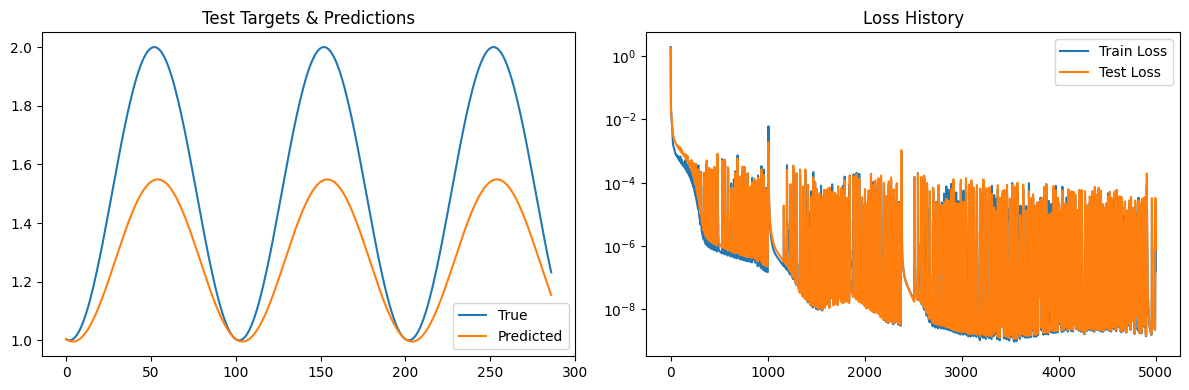

Epoch [50000/50000], Train Loss: 1.5996872093637649e-07, Test Loss: 7.729961453151191e-07


In [130]:
torch.manual_seed(1)

# Initialize the model
net = Network(LSTM_INPUT_SIZE, LSTM_HIDDEN_SIZE, LSTM_LAYERS_N, DROPOUT_P)
net.apply(init_weights)
net = net.to(device)

# Specify loss function and optimizer
#optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE_ADAM, weight_decay=L2_WEIGHT_DECAY)
#optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATE_ADAGRAD, weight_decay=L2_WEIGHT_DECAY)
#optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE_SGD, momentum=0.9, weight_decay=L2_WEIGHT_DECAY)
#optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE_RMS_PROP, weight_decay=L2_WEIGHT_DECAY)
#optimizer = optim.RAdam(net.parameters(), lr=LEARNING_RATE_RADAM, weight_decay=L2_WEIGHT_DECAY)
optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE_ADAMW, weight_decay=L2_WEIGHT_DECAY)

# Create the learning rate scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

#loss_func = nn.L1Loss(reduction='mean')
loss_func = nn.MSELoss(reduction='mean')

# Track the loss history for both training and testing
loss_track = LossTracker()

# Training loop
for epoch in range(EPOCHS_N):
    train_preds = net(train_seqs)
    train_loss = loss_func(train_preds, train_targets.squeeze(-1))

    use_loss = train_loss
    if L1_REGULARIZATION > 0.0:
        l1_reg = 0.0
        for param in net.parameters():
            l1_reg += torch.norm(param, 1)
        use_loss += L1_REGULARIZATION * l1_reg

    optimizer.zero_grad()
    use_loss.backward()
    optimizer.step()

    # Step the scheduler
    #scheduler.step()

    isFirstOrLastEpoch = (epoch == 0 or epoch == (EPOCHS_N - 1))

    if isFirstOrLastEpoch or (epoch % 10) == 0:
        net.eval()  # Switch to evaluation mode
        with torch.no_grad():
            test_preds = net(test_seqs)
            test_loss = loss_func(test_preds, test_targets.squeeze(-1))

        loss_track.add_loss(train_loss.item(), test_loss.item())
        net.train()  # Switch back to training mode

    if (epoch + 1) % 500 == 0:
        net.eval()  # Switch to evaluation mode

        test_preds_vec = []
        for i in range(len(test_seqs)):
            sequence = test_seqs[i].unsqueeze(0)
            pred = net(sequence).item()
            test_preds_vec.append(denormalizeVal(pred))

        test_preds = torch.tensor(test_preds_vec)
        test_preds = test_preds * train_std + train_mean

        # Clear previous plots
        clear_output(wait=True)

        # Create a figure
        fig, axs = plt.subplots(1, 2, figsize=(12,4))

        # Plot the targets and predictions
        axs[0].plot(test_targets.cpu().numpy(), label='True')
        axs[0].plot(test_preds.cpu().numpy(), label='Predicted')
        axs[0].set_title('Test Targets & Predictions')
        axs[0].legend()

        # Plot the loss history
        loss_track.plot_losses(axs[1])

        plt.tight_layout()
        plt.show()

        print(f"Epoch [{epoch+1}/{EPOCHS_N}], Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}")

        net.train()  # Switch back to training mode
